In [1]:
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
# from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import numpy as np
import GPy
import matplotlib.pyplot as plt

In [2]:
## Read PM2.5 data at June 05, 2019
df1 = pd.read_csv('C:\git\DeepKriging\covariate0605.csv')
df2 = pd.read_csv('C:\git\DeepKriging\pm25_0605.csv')

In [3]:
df1.head(5)

,Unnamed: 0,long,lat,prec,temp,pres,rh,uwind,vwind
0,41242,-69.111491,47.386418,0.283942,278.605652,96929.570312,79.589600,4.852976,1.651037
1,41243,-68.736976,47.244262,0.276129,278.605652,97242.070312,79.589600,4.470163,1.646155
2,41244,-68.364554,47.100850,0.276129,279.753113,98692.070312,75.652100,4.477976,1.624670
3,41245,-67.994227,46.956192,0.604254,280.398621,98792.070312,77.417725,4.096140,1.615881
4,41589,-69.318835,47.131182,0.174567,278.424988,96567.070312,77.456787,5.140085,1.481116


In [4]:
df2.head(5)

,Unnamed: 0,Longitude,Latitude,PM25,PM_class
0,1,-80.482778,25.471944,4.400000,1
1,2,-80.215556,25.794222,4.929167,1
2,3,-97.493830,25.892518,8.213636,1
3,4,-80.326389,25.941944,4.100000,1
4,5,-80.256944,26.053889,4.992754,1


In [5]:
covariates = df1.values[:,3:]
covariates.shape

(7706, 6)

In [6]:
aqs_lonlat=df2.values[:,[1,2]]
aqs_lonlat.shape

(842, 2)

### Pair the long and lat based on the nearest neighbor

In [7]:
from scipy import spatial
near = df1.values[:,[1,2]]
tree = spatial.KDTree(list(zip(near[:,0].ravel(), near[:,1].ravel())))
tree.data
idx = tree.query(aqs_lonlat)[1]

In [8]:
df2_new = df2.assign(neighbor = idx)
df_pm25 = df2_new.groupby('neighbor')['PM25'].mean()
df_pm25_class = pd.cut(df_pm25,bins=[-0.1,12.1,35.5],labels=["0","1"])
    # cut 기준을 0부터 해서 오류가 발생함. -0.1부터 시작하면 오류가 발생하지 않음.
idx_new = df_pm25.index.values

In [9]:
pm25 = df_pm25.values
pm25_class = np.array(df_pm25_class.values, dtype=int)
z = pm25[:,None]
z_class = pm25_class[:,None]

In [10]:
lon = df1.values[:,1]
lat = df1.values[:,2]
normalized_lon = (lon-min(lon))/(max(lon)-min(lon))
normalized_lat = (lat-min(lat))/(max(lat)-min(lat))
N = lon.shape[0]

In [11]:
num_basis = [10**2,19**2,37**2]
knots_1dx = [np.linspace(0,1,int(np.sqrt(i))) for i in num_basis]
knots_1dy = [np.linspace(0,1,int(np.sqrt(i))) for i in num_basis]
##Wendland kernel
basis_size = 0
phi = np.zeros((N, sum(num_basis)))
for res in range(len(num_basis)):
    theta = 1/np.sqrt(num_basis[res])*2.5
    knots_x, knots_y = np.meshgrid(knots_1dx[res],knots_1dy[res])
    knots = np.column_stack((knots_x.flatten(),knots_y.flatten()))
    for i in range(num_basis[res]):
        d = np.linalg.norm(np.vstack((normalized_lon,normalized_lat)).T-knots[i,:],axis=1)/theta
        for j in range(len(d)):
            if d[j] >= 0 and d[j] <= 1:
                phi[j,i + basis_size] = (1-d[j])**6 * (35 * d[j]**2 + 18 * d[j] + 3)/3
            else:
                phi[j,i + basis_size] = 0
    basis_size = basis_size + num_basis[res]

In [12]:
## Romove the all-zero columns
idx_zero = np.array([], dtype=int)
for i in range(phi.shape[1]):
    if sum(phi[:,i]!=0)==0:
        idx_zero = np.append(idx_zero,int(i))

In [13]:
phi_reduce = np.delete(phi,idx_zero,1)
print(phi.shape)
print(phi_reduce.shape)

(7706, 1830)
(7706, 1486)


In [14]:
phi_obs = phi_reduce[idx_new,:]
s_obs = np.vstack((normalized_lon[idx_new],normalized_lat[idx_new])).T
X = covariates[idx_new,:]
normalized_X = X
for i in range(X.shape[1]):
    normalized_X[:,i] = (X[:,i]-min(X[:,i]))/(max(X[:,i])-min(X[:,i]))
N_obs = X.shape[0]

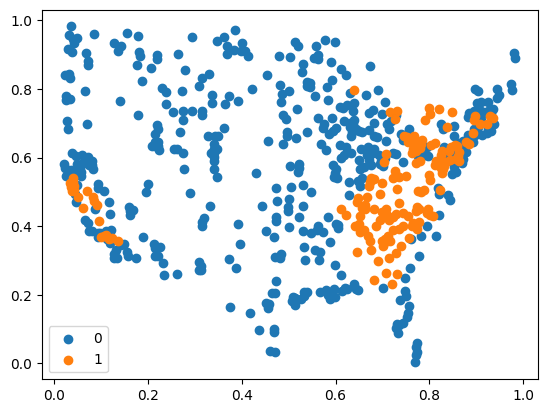

In [15]:
# scatter plot of the circles dataset with points colored by class
from numpy import where
from matplotlib import pyplot
# select indices of points with each class label
for i in range(2):
	samples_ix = where(z_class[:,0] == i)
	pyplot.scatter(s_obs[samples_ix, 0], s_obs[samples_ix, 1], label=str(i))
pyplot.legend()
pyplot.show()

In [16]:
## Save the prepocessed data for Kriging
z_log = np.log(z)
kriging = np.concatenate((s_obs, normalized_X, z, z_class,z_log),axis=1)
traindf=pd.DataFrame(kriging)
traindf.to_csv('C:\git\DeepKriging\kriging.csv')

 C:\Users\권헌정\AppData\Local\Temp\ipykernel_26460\3413144608.py:2: RuntimeWarning:divide by zero encountered in log


## DeepKriging and baseline DNN performance

### Load the useful functions

In [17]:
def deep_model(model, X_train, y_train, X_valid, y_valid, data_type):
    '''
    Function to train a multi-class model. The number of epochs and 
    batch_size are set by the constants at the top of the
    notebook. 
    
    Parameters:
        model : model with the chosen architecture
        X_train : training features
        y_train : training target
        X_valid : validation features
        Y_valid : validation target
    Output:
        model training history
    '''
    if data_type == 'continuous':
        model.compile(optimizer='adam'
                      , loss='mse'
                      , metrics=['mse','mae'])
    if data_type == 'discrete':
        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    history = model.fit(X_train
                       , y_train
                       , epochs=NB_START_EPOCHS
                       , batch_size=BATCH_SIZE
                       , validation_data=(X_valid, y_valid)
                       , verbose=0)
    return history

def test_model(model, X_train, y_train, X_test, y_test, epoch_stop):
    '''
    Function to test the model on new data after training it
    on the full training data with the optimal number of epochs.
    
    Parameters:
        model : trained model
        X_train : training features
        y_train : training target
        X_test : test features
        y_test : test target
        epochs : optimal number of epochs
    Output:
        test accuracy and test loss
    '''
    model.fit(X_train
              , y_train
              , epochs=epoch_stop
              , batch_size=BATCH_SIZE
              , verbose=0)
    results = model.evaluate(X_test, y_test, verbose=0)
    return results
    
def optimal_epoch(model_hist):
    '''
    Function to return the epoch number where the validation loss is
    at its minimum
    
    Parameters:
        model_hist : training history of model
    Output:
        epoch number with minimum validation loss
    '''
    min_epoch = np.argmin(model_hist.history['val_loss']) + 1
    return min_epoch

### Specify the model structure

In [18]:
# DeepKriging model for continuous data
p = covariates.shape[1] + phi_reduce.shape[1]
model = Sequential()
model.add(Dense(100, input_dim = p,  kernel_initializer='he_uniform', activation='relu'))
model.add(Dropout(rate=0.5))
model.add(BatchNormalization())
model.add(Dense(100, activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(100, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(1, activation='linear'))

In [19]:
# DeepKriging model for categorical data
model_class = Sequential()
model_class.add(Dense(100, input_dim = p,  kernel_initializer='he_uniform', activation='relu'))
model_class.add(Dropout(rate=0.5))
model_class.add(BatchNormalization())
model_class.add(Dense(100, activation='relu'))
model_class.add(Dropout(rate=0.5))
model_class.add(Dense(100, activation='relu'))
model_class.add(BatchNormalization())
model_class.add(Dense(1, activation='sigmoid'))

In [20]:
# Baseline DNN only with covariates and coordinates
p_base = covariates.shape[1] + s_obs.shape[1]
# Neural network
model_base = Sequential()
model_base.add(Dense(100, input_dim=p_base,  kernel_initializer='he_uniform', activation='relu'))
model_base.add(Dropout(rate=0.5))
model_base.add(BatchNormalization())
model_base.add(Dense(100, activation='relu'))
model_base.add(Dropout(rate=0.5))
model_base.add(Dense(100, activation='relu'))
model_base.add(BatchNormalization())
model_base.add(Dense(1, activation='linear'))

In [21]:
# Baseline DNN for classification
model_base_class = Sequential()
model_base_class.add(Dense(100, input_dim=p_base,  kernel_initializer='he_uniform', activation='relu'))
model_base_class.add(Dropout(rate=0.5))
model_base_class.add(BatchNormalization())
model_base_class.add(Dense(100, activation='relu'))
model_base_class.add(Dropout(rate=0.5))
model_base_class.add(Dense(100, activation='relu'))
model_base_class.add(BatchNormalization())
model_base_class.add(Dense(1, activation='sigmoid'))

### Run cross-validation

In [22]:
from sklearn.model_selection import KFold
NB_START_EPOCHS = 200  # Number of epochs we usually start to train with
BATCH_SIZE = 64  # Size of the batches used in the mini-batch gradient descent

In [23]:
# 10-fold cross-validation
num_folds = 10
kfold = KFold(n_splits=num_folds, shuffle=True, random_state = 123)
fold_no = 1
inputs = np.hstack((normalized_X,phi_obs))
inputs_base = np.hstack((normalized_X,s_obs))
targets = z
targets_class = z_class
mse_per_fold = []
mse_per_fold_base = []
mae_per_fold = []
mae_per_fold_base = []
acc_per_fold = []
acc_per_fold_base = []
for train_idx, test_idx in kfold.split(inputs, targets):
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')
    history = deep_model(model, inputs[train_idx], targets[train_idx,0:1]\
                              , inputs[test_idx], targets[test_idx,0:1],'continuous')
    history_base = deep_model(model_base, inputs_base[train_idx], targets[train_idx,0:1]\
                              , inputs_base[test_idx], targets[test_idx,0:1],'continuous')
    ## Classification
    history_class = deep_model(model_class, inputs[train_idx], targets_class[train_idx,0:1]\
                              , inputs[test_idx], targets_class[test_idx,0:1],'discrete')
    history_base_class = deep_model(model_base_class, inputs_base[train_idx], targets_class[train_idx,0:1]\
                              , inputs_base[test_idx], targets_class[test_idx,0:1],'discrete')
    model_optim = 200 #optimal_epoch(history)
    model_optim_base = 200 #optimal_epoch(history_base)
    result = test_model(model, inputs[train_idx], targets[train_idx,0:1], inputs[test_idx]\
                        , targets[test_idx,0:1], model_optim)
    result_base = test_model(model_base, inputs_base[train_idx], targets[train_idx,0:1], inputs_base[test_idx]\
                             , targets[test_idx,0:1], model_optim_base)
    scores = result
    scores_base = result_base
    print(f'The performance of DeepKriging: MSE = {scores[1]}, MAE = {scores[2]}')
    print(f'The performance of classical DNN: MSE = {scores_base[1]}, MAE = {scores_base[2]}')
    model_optim_class = 200 #optimal_epoch(history_class)
    model_optim_base_class = 200 #optimal_epoch(history_base_class)
    result_class = test_model(model_class, inputs[train_idx], targets_class[train_idx,0:1], inputs[test_idx]\
                        , targets_class[test_idx,0:1], model_optim_class)
    result_base_class = test_model(model_base_class, inputs_base[train_idx], targets_class[train_idx,0:1], inputs_base[test_idx]\
                             , targets_class[test_idx,0:1], model_optim_base_class)
    scores_class = result_class
    scores_base_class = result_base_class
    print(f'The performance of DeepKriging: accuracy = {scores_class[1]}')
    print(f'The performance of classical DNN: accuracy = {result_base_class[1]}')
    fold_no = fold_no + 1
    acc_per_fold.append(scores_class[1])
    acc_per_fold_base.append(scores_base_class[1])
    mse_per_fold.append(scores[1])
    mse_per_fold_base.append(scores_base[1])
    mae_per_fold.append(scores[2])
    mae_per_fold_base.append(scores_base[2])

------------------------------------------------------------------------
Training for fold 1 ...
The performance of DeepKriging: MSE = 6.00222110748291, MAE = 1.7915234565734863
The performance of classical DNN: MSE = 5.694897651672363, MAE = 1.7589246034622192
The performance of DeepKriging: accuracy = 0.8524590134620667
The performance of classical DNN: accuracy = 0.868852436542511
------------------------------------------------------------------------
Training for fold 2 ...
The performance of DeepKriging: MSE = 3.218496799468994, MAE = 1.3232136964797974
The performance of classical DNN: MSE = 3.857404947280884, MAE = 1.5494147539138794
The performance of DeepKriging: accuracy = 0.9016393423080444
The performance of classical DNN: accuracy = 0.868852436542511
------------------------------------------------------------------------
Training for fold 3 ...
The performance of DeepKriging: MSE = 2.179072380065918, MAE = 1.0048569440841675
The performance of classical DNN: MSE = 5.2793

In [24]:
##Summerize the results with meassage
print(np.mean(mse_per_fold))
print(np.std(mse_per_fold))
print(np.mean(mse_per_fold_base))
print(np.std(mse_per_fold_base))
print(np.mean(mae_per_fold))
print(np.std(mae_per_fold))
print(np.mean(mae_per_fold_base))
print(np.std(mae_per_fold_base))
print(np.mean(acc_per_fold))
print(np.std(acc_per_fold))
print(np.mean(acc_per_fold_base))
print(np.std(acc_per_fold_base))

2.3502652615308763
1.4488582069137403
4.06573851108551
1.240307725129317
1.0393630266189575
0.32265573518842783
1.5082778334617615
0.24211413560987516
0.927404373884201
0.0367611831772677
0.8893169283866882
0.033558871693821254


In [25]:
## Save the same test index for Kriging
train_idx_combine = []
test_idx_combine = []
for train_idx, test_idx in kfold.split(inputs, targets):
    train_idx_combine.append(train_idx)
    test_idx_combine.append(test_idx)  
test_df = pd.DataFrame(test_idx_combine).T
test_df.to_csv('C:\git\DeepKriging/test_idx.csv')

### The case without covariates

In [26]:
# DeepKriging model for continuous data
p2 =  phi_reduce.shape[1]
model_nx = Sequential()
model_nx.add(Dense(100, input_dim = p2,  kernel_initializer='he_uniform', activation='relu'))
model_nx.add(Dropout(rate=0.5))
model_nx.add(BatchNormalization())
model_nx.add(Dense(100, activation='relu'))
model_nx.add(Dropout(rate=0.5))
model_nx.add(Dense(100, activation='relu'))
model_nx.add(BatchNormalization())
model_nx.add(Dense(1, activation='linear'))

In [27]:
# DeepKriging model for categorical data
model_class_nx = Sequential()
model_class_nx.add(Dense(100, input_dim = p2,  kernel_initializer='he_uniform', activation='relu'))
model_class_nx.add(Dropout(rate=0.5))
model_class_nx.add(BatchNormalization())
model_class_nx.add(Dense(100, activation='relu'))
model_class_nx.add(Dropout(rate=0.5))
model_class_nx.add(Dense(100, activation='relu'))
model_class_nx.add(BatchNormalization())
model_class_nx.add(Dense(1, activation='sigmoid'))

In [28]:
inputs = phi_obs
inputs_base = s_obs
targets = z
targets_class = z_class
mse_per_fold_nx = []
mae_per_fold_nx = []
acc_per_fold_nx = []
fold_no = 1
for train_idx, test_idx in kfold.split(inputs, targets):
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')
    history_nx = deep_model(model_nx, inputs[train_idx], targets[train_idx,0:1]\
                              , inputs[test_idx], targets[test_idx,0:1],'continuous')
    ## Classification
    history_class_nx = deep_model(model_class_nx, inputs[train_idx], targets_class[train_idx,0:1]\
                              , inputs[test_idx], targets_class[test_idx,0:1],'discrete')
    model_optim_nx = 200#optimal_epoch(history_nx)
    result_nx = test_model(model_nx, inputs[train_idx], targets[train_idx,0:1], inputs[test_idx]\
                        , targets[test_idx,0:1], model_optim_nx)
    scores_nx = result_nx
    print(f'The performance of DeepKriging without X: MSE = {scores_nx[1]}, MAE = {scores_nx[2]}')
    model_optim_class_nx = 200#optimal_epoch(history_class_nx)
    result_class_nx = test_model(model_class_nx, inputs[train_idx], targets_class[train_idx,0:1], inputs[test_idx]\
                        , targets_class[test_idx,0:1], model_optim_class_nx)
    scores_class_nx = result_class_nx
    print(f'The performance of DeepKriging without X: accuracy = {scores_class_nx[1]}')
    fold_no = fold_no + 1
    acc_per_fold_nx.append(scores_class_nx[1])
    mse_per_fold_nx.append(scores_nx[1])
    mae_per_fold_nx.append(scores_nx[2])

------------------------------------------------------------------------
Training for fold 1 ...
The performance of DeepKriging without X: MSE = 5.687574863433838, MAE = 1.7708925008773804
The performance of DeepKriging without X: accuracy = 0.8360655903816223
------------------------------------------------------------------------
Training for fold 2 ...
The performance of DeepKriging without X: MSE = 3.136072874069214, MAE = 1.3223639726638794
The performance of DeepKriging without X: accuracy = 0.9016393423080444
------------------------------------------------------------------------
Training for fold 3 ...
The performance of DeepKriging without X: MSE = 2.202849864959717, MAE = 1.0512882471084595
The performance of DeepKriging without X: accuracy = 0.9180327653884888
------------------------------------------------------------------------
Training for fold 4 ...
The performance of DeepKriging without X: MSE = 2.33182954788208, MAE = 1.1514394283294678
The performance of DeepKrigin

In [29]:
print(np.mean(mse_per_fold_nx))
print(np.std(mse_per_fold_nx))
print(np.mean(mae_per_fold_nx))
print(np.std(mae_per_fold_nx))
print(np.mean(acc_per_fold_nx))
print(np.std(acc_per_fold_nx))

2.033409535884857
1.43389193029597
0.9982266783714294
0.32793796727338204
0.9324043691158295
0.03897618858696521


## Prediction

In [30]:
covariates

array([[ 2.83941597e-01,  2.78605652e+02,  9.69295703e+04,
         7.95895996e+01,  4.85297585e+00,  1.65103745e+00],
       [ 2.76129097e-01,  2.78605652e+02,  9.72420703e+04,
         7.95895996e+01,  4.47016335e+00,  1.64615464e+00],
       [ 2.76129097e-01,  2.79753113e+02,  9.86920703e+04,
         7.56520996e+01,  4.47797585e+00,  1.62467027e+00],
       ...,
       [ 3.93316597e-01,  2.93506042e+02,  1.00979570e+05,
         7.11989822e+01,  1.48481190e+00, -3.00521255e+00],
       [ 2.06519151e+00,  2.92847839e+02,  1.01029570e+05,
         7.33864746e+01,  1.86274159e+00, -2.99056411e+00],
       [ 8.73706627e+00,  2.92403503e+02,  1.01292070e+05,
         7.79099121e+01,  1.79731190e+00, -3.06185317e+00]])

In [31]:
inputs = np.hstack((normalized_X,phi_obs))
targets = z
history = deep_model(model, inputs, targets[:,0:1], inputs, targets[:,0:1],'continuous')

In [32]:
X_pred = covariates
normalized_X_pred = X_pred
for i in range(X_pred.shape[1]):
    normalized_X_pred[:,i] = (X_pred[:,i]-min(X[:,i]))/(max(X[:,i])-min(X[:,i]))

In [33]:
X_RBF_pred = np.hstack((normalized_X_pred,phi_reduce))
PM25_pred = model.predict(X_RBF_pred)

241/241 [==============================] - 0s 848us/step


In [34]:
s = np.vstack((normalized_lon,normalized_lat)).T
PM25_pred_combine = np.concatenate((s,normalized_X_pred,PM25_pred),axis=1)
PM25_pred_df=pd.DataFrame(PM25_pred_combine)
PM25_pred_df.to_csv('C:\git\DeepKriging\PM25_pred_0605.csv')

### Risk

In [35]:
import sys
sys.path.append('../')
from dcdr.deep_hist import Binning_CDF
from scipy.stats import iqr
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib;matplotlib.rcParams['figure.figsize'] = (8,6)
init_seed=1
num_cut = int((max(z)-min(z))*N**(1/3)/(2*iqr(z)))
hidden_list = [100,100,100]
dropout_list = [0.5,0.5,0.5]
histogram_bin = 'random'
loss_model = 'multi-binary'
seeding = 1

In [36]:
import tensorflow as tf

# GPU 설정
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # 첫 번째 GPU만 사용하도록 설정
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        
        # GPU 메모리 할당을 동적으로 조정
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)

In [38]:
dcdr_model = Binning_CDF(num_cut=num_cut, hidden_list=hidden_list,
                         histogram_bin=histogram_bin, dropout_list=dropout_list,
                         seeding=seeding, loss_model=loss_model, 
                         niter=10)
    
dcdr_model.fit_cdf(inputs, targets, batch_size=32, merge_empty_bin=True)

AttributeError: module 'tensorflow' has no attribute 'set_random_seed'

In [ ]:
risk = dcdr_model.predict_cdf(X_RBF_pred,pred_lim=[12,12],ngrid=1)

# 모형별 예측밴드 그려보는 작업이 있으면 좋을것 같습니다.

In [ ]:
riskdf=pd.DataFrame(risk)
riskdf.to_csv('C:\git\DeepKriging/risk_pred.csv')